In [1]:
import cv2
from __future__ import division, print_function
import numpy as np
# given an image and a list of points, we want to extract patches s.t. they are centered (vertically) on the tail edge
# we also want to extract negative patches, but this is a different task
def extract(img, center, size):
    # assume center is in x, y format
    upper_border = center[1] - size[0]//2
    lower_border = center[1] + size[0]//2
    left_border = center[0] - size[1]//2
    right_border = center[0] + size[1]//2
    
    extracted_patch = img[max(0,upper_border):min(img.shape[0],lower_border),
                          max(0,left_border):min(img.shape[1],right_border)]
    
    fillrow_amount = 0
    if upper_border < 0:
        fillrow_amount = upper_border
    elif lower_border > img.shape[0]: # assume that the patch's y isn't > img's y
        fillrow_amount = lower_border - img.shape[0]
    
    # fill the row before we fill the col if we need to
    if fillrow_amount != 0:
        tovstack = [extracted_patch]
        if fillrow_amount < 0:
            tovstack.insert(0,[extracted_patch[0,:]]*abs(fillrow_amount))
        else:
            tovstack.append([extracted_patch[-1,:]]*fillrow_amount)
        extracted_patch = np.vstack(tovstack)
            
    fillcol_amount = None
    if left_border < 0:
        fillcol_amount = left_border
    elif right_border > img.shape[1]:
        fillcol_amount = right_border - img.shape[1]
    
    if fillcol_amount != 0:
        tohstack = [extracted_patch]
        if fillcol_amount < 0:
            tohstack.insert(0,[extracted_patch[:,0].reshape(-1,1)]*abs(fillcol_amount))
        else:
            tohstack.append([extracted_patch[:,-1].reshape(-1,1)]*fillcol_amount)
        extracted_patch = np.hstack(tohstack)
    
    assert(extracted_patch.shape == size)
    return extracted_patch, upper_border
    
def find_best_y(img, lower_real_coord):    
    centerx = img.shape[1] // 2
    gradient_y_image = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
    new_y_center = np.argmax(gradient_y_image[:,centerx])
    return new_y_center

def extract_candidates(img, point_list, size):
    candidates = []
    for point in point_list:
        initial_candidate, upper_border = extract(img, size, point)
        new_y_center = upper_border + find_best_y(initial_candidate) # point is x,y
        candidates.append(extract(img, size, (point[0],new_y_center)))
    return candidates

def line_between(p1, p2):
    # return a function that gives the line between p1 and p2
    # so that we can extract patches along that line
    d = (p2[0] - p1[0], p2[1] - p1[1])
    return lambda t: (p1[0] + t*d[0], p1[1] + t*d[1]) 

def sample_along_line(p1, p2, size):
    # we want to determine how many steps along the line we'll sample so that we have no overlapping boxes
    # we can assume that p1[x] < p2[x], i.e. we're going left to right
    # if the angle that the line between p1 and p2 makes is between 45 and -45
    line = line_between(p1, p2)
    dX = p2[0] - p1[0]
    dY = p2[1] - p1[1]
    distance = np.sqrt(dX**2 + dY**2)
    angle_between = np.arctan2(-1*dY,dX) # multiply by -1 since Y increases as it goes down
    if abs(angle_between) > (np.pi / 4):
        movement_amount = np.sin(angle_between)*size[1] # assume size[1] is y
    else:
        movement_amount = np.cos(angle_between)*size[0] # assume size[0] is x
    line_percentage = 0.75*min(1.,abs(movement_amount) / distance)
    t = 0 #line_percentage # the first one will be right outside of the bounding box
    centers = []
    while(t < (1-line_percentage)):
        centers.append(line(t + line_percentage))
        t += line_percentage
    return centers

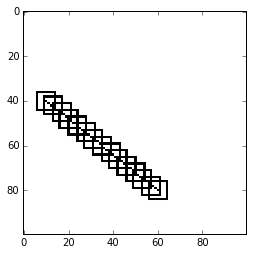

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

def display_boxes(canvas_size, p1, p2, size):
    canvas = np.ones(canvas_size)
    all_points = [p1] + sample_along_line(p1, p2, size) + [p2]
    for point in all_points:
        upper_left = tuple(map(int,(point[0] - size[0]//2, point[1] - size[1]//2)))
        bottom_right = tuple(map(int,(point[0] + size[0]//2, point[1] + size[1]//2)))
        #print(upper_left)
        #print(bottom_right)
        cv2.rectangle(canvas, upper_left, bottom_right, color=0)
    cv2.line(canvas, p1, p2, color=0)
    plt.gray()
    plt.imshow(canvas,interpolation='none')
    

#sample_along_line((10,200),(30,400),(16,16))
display_boxes((100,100),(10,40),(60,80),(8,8))   

In [3]:
from scipy.stats import norm
def find_seam(img, start, end, center=None, n_neighbors=3, scale=1):
    assert(n_neighbors % 2 == 1)
    #n_neighbors = img.shape[0]
    neighbor_range = range(-1*(n_neighbors // 2),1+(n_neighbors // 2))
    #weight_df = [norm.pdf(x, scale=scale) for x in neighbor_range]
    # start and end are x,y 
    # take the vertical gradients of the image
    gradient_y_image = 1*cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
    # TODO maybe: blur before taking gradients to denoise
    # set the start point's vertical gradient to a very high value
    # for each row from start to end, the cost of each cell is the max
    # of the three neighbors to its left + its own cost
    # the max that is chosen is then stored for each pixel in a column so we can backtrack
    gradient_y_image[:,start[0]] = np.inf # make sure this is where the path starts
    gradient_y_image[start[1],start[0]] = 0 #np.max(gradient_y_image) + 1 # yeah I think this makes sense
    
    gradient_y_image[:,end[0]] = np.inf
    gradient_y_image[end[1],end[0]] = 0 #np.max(gradient_y_image) + 1
    if center is not None:
        # force it to go through the center
        gradient_y_image[:,center[0]] = np.inf
        gradient_y_image[center[1],center[0]] = 0
    # the goal of the above is to make the path end at 'end', but that probably can't be guaranteed regardless
    cost = np.zeros(gradient_y_image.shape)
    back = np.zeros(gradient_y_image.shape,dtype=np.int32)
    get_cost = lambda row, col, i : np.inf if ((row+i < 0) or (row+i >= gradient_y_image.shape[0])) else cost[row+i,col-1] + gradient_y_image[row,col]
    for col in range(start[0],end[0]+1):
        # this is the slow part
        for row in range(gradient_y_image.shape[0]):
            #candidates = [((cost[cell+i, col-1]+gradient_y_image[cell,col]) if
            #              ((cell+i > 0) and (cell+i < gradient_y_image.shape[0])) else -np.inf) 
            #              for i in (-1,0,1)]
            #print(get_cost(row, col, 1))
            candidates = [get_cost(row, col, i) for i in neighbor_range]
            best = np.argmin(candidates)
            #print(candidates)
            back[row, col] = best - (n_neighbors // 2)
            cost[row, col] = candidates[best]
    # backtrack the seam
    path = [] # we know that the path is from end to start so we don't need to store the x values
    curr_y = end[1]
    path_cost = 0
    # we know that the optimal path must end at the end point since otherwise its cost is -inf
    for col in range(start[0],end[0]+1)[::-1]:
        path_cost += cost[curr_y,col]
        path.append((col,curr_y)) 
        next_ = curr_y + back[curr_y,col]
        curr_y = next_
    #plt.imshow(cost)
    return path, path_cost, cost

In [4]:
with open('../dataset_loc','r') as f:
    dataset_loc = f.read().rstrip()
from os.path import join
import random
import glob
imgs_dir = join(dataset_loc,'Flukes/CRC_combined constrained/')
all_imgfn = glob.glob(join(imgs_dir,'*'))
test_img = cv2.cvtColor(cv2.imread(random.choice(all_imgfn)),cv2.COLOR_BGR2GRAY)
print(test_img.shape)
start = (0,0)
end = (950,0)
path, path_cost, test_cost = find_seam(test_img, start,end, n_neighbors=5)
print(path_cost)
print(path[0])
print(path[-1])

        

(319, 960)
-1472901651.0
(950, 0)
(0, 0)


In [5]:
def color_path(img, path):
    color_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    for col, row in path:
        color_img = cv2.circle(color_img, (col, row), radius=2, color=(255,0,0))
    return color_img
    
colored_img = color_path(test_img, path)

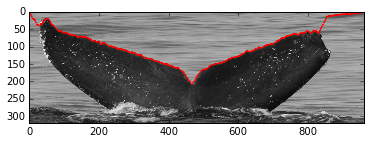

In [6]:
plt.imshow(colored_img)

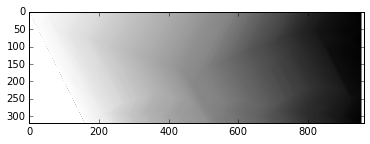

In [7]:
plt.imshow(test_cost)

In [8]:
import cPickle as pickle
def load_coords():
    with open(join(dataset_loc, 'Flukes/extracted_zsl_annotations.pkl'), 'r') as f:
        return pickle.load(f)
coords_id_img_map = load_coords()

In [9]:
def path_from_patch(patch_coord, img, n_neighbors=7):
    left = patch_coord['left']
    right = patch_coord['right']
    center = patch_coord['notch']
    
    path, path_cost, cost_img = find_seam(img, left, right, center=center, n_neighbors=n_neighbors)
    return path, path_cost, cost_img

In [10]:
# compute the curvature feature from: Fischer and Brox, “Image Descriptors Based on Curvature Histograms.”
from itertools import product  

def get_curvature_along_path(img, path): # assume img is grayscale
    # return 4d tensor s.t. jac[:,i,j].shape = (4), if you do a reshape(2,2) it will work out to the jacobian
    gy = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
    gx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
    tangnorm = np.linalg.norm(np.dstack([-1*gy, gx]),axis=2) + 1e-7
    gnorm = np.linalg.norm(np.dstack([gx,gy]),axis=2) + 1e-7
    gyN = gy / gnorm
    gxN = gx / gnorm

    gyNy = cv2.Sobel(gyN,cv2.CV_64F,0,1,ksize=5)
    gyNx = cv2.Sobel(gyN,cv2.CV_64F,1,0,ksize=5)
    gxNy = cv2.Sobel(gxN,cv2.CV_64F,0,1,ksize=5)
    gxNx = cv2.Sobel(gxN,cv2.CV_64F,1,0,ksize=5)
    jac_norm = np.linalg.norm(np.dstack([gxNx, gxNy, gyNy, gyNx]),axis=2) + 1e-7
    gyNy /= jac_norm
    gyNx /= jac_norm
    gxNy /= jac_norm
    gxNx /= jac_norm
    
    
    jac = np.dstack([[gxNx, gxNy],[gyNy, gyNx]]).reshape(img.shape[0],img.shape[1],2,2)
    gN = np.dstack([gxN,gyN])
    tangN = np.dstack([-1*gy / tangnorm, gx / tangnorm]).reshape(img.shape[0],img.shape[1],2,1)
    
    #Q = np.zeros((img.shape[0],img.shape[1],2))
    path_curvatures = []
    # TODO: figure out how to do this in pure numpy, which may be faster than doing it on the path points
    for j, i in path: # assume path is in x,y format
        q_ij = np.dot(np.dot(tangN[i,j].T, jac[i,j]),tangN[i,j]).flatten()[0] / 2
        path_curvatures.append([gxN[i,j]*q_ij,gyN[i,j]*q_ij])
    #Q = np.dstack([gxN*q,gyN*q])
    return np.array(path_curvatures)


test_Q = get_curvature_along_path(test_img, path)

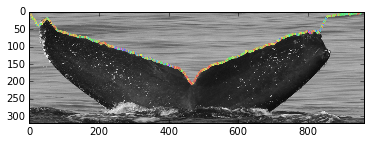

In [11]:
from matplotlib.colors import hsv_to_rgb
def draw_curvature_on_path(img, path, curvatures):
    drawn_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    for (col, row), Q in zip(path, curvatures):
        magnitude = np.linalg.norm(Q)
        h = magnitude
        s = 0.6
        v = 0.9
        rgb = hsv_to_rgb((h,s,v))*255
        #print(rgb*255)
        drawn_img = cv2.circle(drawn_img, (col, row), radius=3, color=rgb)
    return drawn_img

Qdrawn_test = draw_curvature_on_path(test_img, path, test_Q)
plt.imshow(Qdrawn_test)

In [12]:
def make_magnitude_hist(curvatures, nbins=4):
    # these don't wrap around like the direction, so we just need to figure out interpolation
    magnitudes = np.linalg.norm(curvatures, axis=1)
    return np.histogram(magnitudes, bins=nbins, range=(0.,1.))

def make_direction_hist(curvatures, nbins=8):
    angles = np.arctan2(curvatures[:,0], curvatures[:,1])
    return np.histogram(angles, bins=nbins, range=(-1*np.pi, np.pi))
    
print(make_magnitude_hist(test_Q, nbins=8))
print(make_direction_hist(test_Q))

(array([350, 201, 176, 114,  53,  37,  13,   7]), array([ 0.   ,  0.125,  0.25 ,  0.375,  0.5  ,  0.625,  0.75 ,  0.875,  1.   ]))
(array([210,  25,  28, 211, 229,  24,  22, 202]), array([-3.14159265, -2.35619449, -1.57079633, -0.78539816,  0.        ,
        0.78539816,  1.57079633,  2.35619449,  3.14159265]))


15266


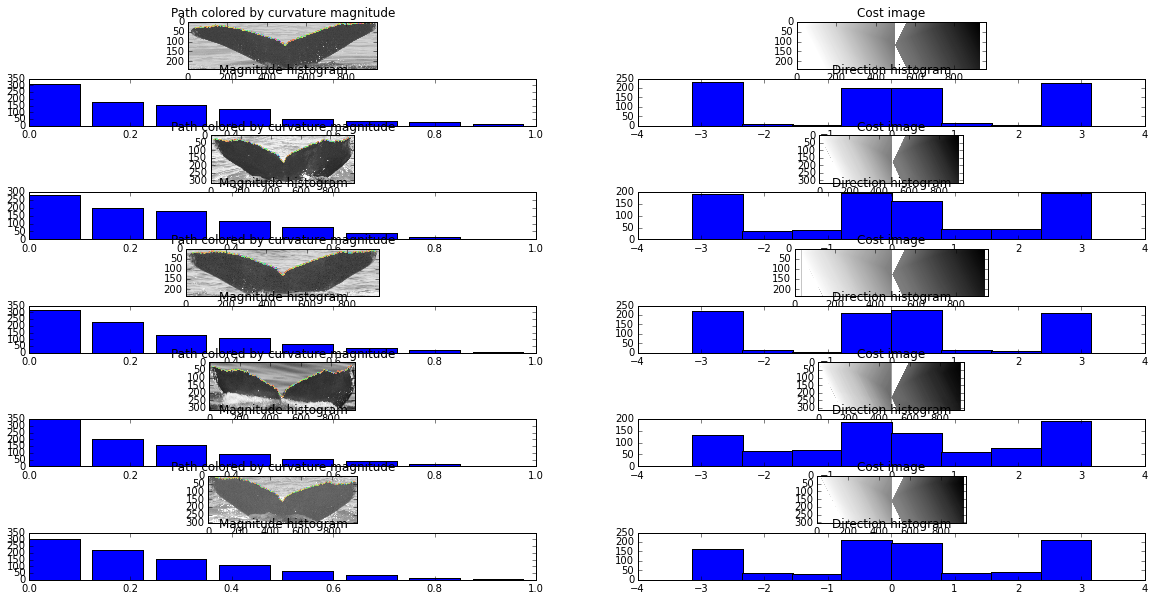

In [13]:
def show_all(indv, coord_map, max_images=10, n_neighbors=3):
    n_img = min(len(coord_map[indv]),max_images)
    fig, axarr = plt.subplots(n_img*2, 2, figsize=(20,10))
    axarr = axarr.reshape(n_img*2, 2)
    for ind, patch_coord in list(enumerate(coord_map[indv]))[:max_images]:
        img_ind = ind*2
        hist_ind = img_ind+1
        img = cv2.cvtColor(cv2.imread(join(imgs_dir, patch_coord['fn'])),cv2.COLOR_BGR2GRAY)
        path, path_cost, cost_img = path_from_patch(patch_coord, img, n_neighbors=n_neighbors)
        #show_img = color_path(img, path)
        Q = get_curvature_along_path(img, path)
        curvature_drawn = draw_curvature_on_path(img, path, Q)
        magnitude_hist = make_magnitude_hist(Q, nbins=8)
        angles_hist = make_direction_hist(Q)
        
        axarr[img_ind,0].set_title("Path colored by curvature magnitude")
        axarr[img_ind,1].set_title("Cost image")
        axarr[img_ind,0].imshow(curvature_drawn)
        axarr[img_ind,1].imshow(cost_img)
        
        axarr[hist_ind,0].set_title("Magnitude histogram")
        axarr[hist_ind,0].bar(magnitude_hist[1][:-1], magnitude_hist[0], width=0.1)
        axarr[hist_ind,1].set_title("Direction histogram")
        axarr[hist_ind,1].bar(angles_hist[1][:-1], angles_hist[0])

rand_indv = random.choice(coords_id_img_map.keys())
#rand_indv = '15130'
print(rand_indv)
show_all(rand_indv, coords_id_img_map, n_neighbors=5)

In [14]:
from scipy.spatial.distance import cosine
def dtw(Q1, Q2):
    tic = time.time()
    dtw = np.zeros((Q1.shape[0],Q2.shape[0]))
    dtw[:,0] = -1*np.inf
    dtw[0,:] = -1*np.inf
    dtw[0,0] = 0
    
    for i in range(1,Q1.shape[0]):
        for j in range(1,Q2.shape[0]):
            #dist = np.linalg.norm(Q1[i,:] - Q2[j,:])
            dist = cosine(Q1[i,:] + 1e-7, Q2[j,:] + 1e-7)
            if np.isnan(dist):
                print("Nan dist: Q1[%d]=%r, Q2[%d]=%r" % (i, Q1[i,:], j, Q2[j,:]))
            dtw[i,j] = dist + max([dtw[i-1, j],
                                   dtw[i, j-1],
                                   dtw[i-1,j-1]])
    toc = time.time() - tic
    print("Took %0.2f seconds" % toc)
    print(dtw)
    return dtw

def dtw_dist(Q1, Q2, window=20):
    tic = time.time()
    dtw = np.zeros((Q1.shape[0],Q2.shape[0])) + np.inf
    #dtw[:,0] = np.inf
    #dtw[0,:] = np.inf
    dtw[0,0] = 0
    window = max(window, abs(Q1.shape[0] - Q2.shape[0]))
    for i in range(1,Q1.shape[0]):
        for j in range(max(1, i-window),min(Q2.shape[0],i+window)):
            #dist = np.linalg.norm(Q1[i,:] - Q2[j,:])
            dist = cosine(Q1[i,:], Q2[j,:])
            dtw[i,j] = dist + max([dtw[i-1, j],
                                   dtw[i, j-1],
                                   dtw[i-1,j-1]])
    toc = time.time() - tic
    print("Took %0.2f seconds" % toc)
    print(dtw)
    return dtw

In [15]:
def get_neighbors(point, img_size):
    neighbors = []
    for i, j in product([1,0,-1],[1,0,-1]):
        if (i == 0) and (j == 0):
            continue
        if ((point[0] + i) >= img_size[0]) or ((point[0] + i) < 0):
            continue
        if ((point[1] + j) >= img_size[1]) or ((point[1] + j) < 0):
            continue
        neighbors.append((point[0]+i, point[1]+j))
    return neighbors


def get_points_in_circle(point, r, binarized_img):
    # basically do a bfs until the distance from the point is > r
    # points are x, y
    queue = [point]
    img_size = binarized_img.shape[::-1]
    points = {}
    while (len(queue)):
        cur = queue.pop()
        neighbors = get_neighbors(cur, img_size)
        dists = [np.linalg.norm(np.array(p) - np.array(point)) for p in neighbors]
        for p, dist in zip(neighbors, dists):
            if dist < r and (p not in points) and (binarized_img[p[1],p[0]] == 1):
                #img[p[1],p[0]] = min(1., (r - dist))
                points[p] = {'weight':min(1., r - dist), 'dist': dist}
                queue.append(p)
            elif dist > r and (binarized_img[p[1],p[0]]) == 1:
                points[cur]['at_edge'] = True
                
        #points = points.union(set(neighbors))
    return points

#points = get_points_in_circle((25,25), 5, (50,50))
#circle_img = np.zeros((50,50))
#path_test = [(i, 25) for i in range(50)]
#for p in points:
#    circle_img[p[1],p[0]] = points[p]['weight']
#plt.imshow(circle_img, interpolation='none')
#print(len(filter(lambda p: 'at_edge' in points[p], points.keys())))
def integral_curvature_naive(binary_img, point, r):
    # TODO: this w/convolutions (as soon as I understand how)
    # get the points within the circle formed by r
    # assume points are x, y
    points = get_points_in_circle(point, r, binary_img)
    points_in_contour = filter(lambda x: binary_img[x[1],x[0]] == 1, points.keys())
    weighted_area = sum([points[p]['weight'] for p in points_in_contour])
    arc_length = len(filter(lambda p: 'at_edge' in points[p], points_in_contour))
    return (weighted_area / (np.pi*(r**2))), (arc_length / (2*np.pi*r)) 

def binarize_img(img, path):
    # everything under the y-value on a path is marked '1'
    # everything else is 0
    binarized = np.zeros(img.shape)
    for p in path:
        binarized[p[1]:,p[0]] = 1
    return binarized

def integral_curvature(img, path, r):
    binarized = binarize_img(img, path)
    return [integral_curvature_naive(binarized, p, r) for p in path]



In [16]:
# for this evaluation we're gonna want a map of
# img -> {id, curvatures}
import time

def get_img_curvature_map(coords, n_neighbors=5, r=5, mbins=8, abins=8):
    curvatures = []
    for ind, crcid in enumerate(coords.keys()):
        tic = time.time()
        path_times = 0
        curvature_times = 0
        integ_times = 0
        for patch_coords in coords[crcid]:
            img = cv2.cvtColor(cv2.imread(join(imgs_dir, patch_coords['fn'])),cv2.COLOR_BGR2GRAY)
            path_tic = time.time()
            path, _, _ = path_from_patch(patch_coords, img, n_neighbors=n_neighbors)
            path_toc = time.time() - path_tic
            path_times += path_toc
            Q_tic = time.time()
            Q = get_curvature_along_path(img, path)
            Q_toc = time.time() - Q_tic
            magnitude_hist = make_magnitude_hist(Q, nbins=mbins)
            angles_hist = make_direction_hist(Q, nbins=abins)
            curvature_times += Q_toc
            #r = 5
            integ_tic = time.time()
            integral_curv = integral_curvature(img, path, r)
            integ_toc = time.time() - integ_tic
            integ_times += integ_toc
            curvatures.append({'id':crcid, 'Q':Q, 
                               'diffhist':{'a':angles_hist[0],'m':magnitude_hist[0]},
                               'path':path, 'fn':patch_coords['fn'], 
                               'int_curv':{r:integral_curv}})

        toc = time.time() - tic
        toc /= len(coords[crcid])
        path_times /= len(coords[crcid])
        curvature_times /= len(coords[crcid])
        integ_times /= len(coords[crcid])
        print("%s took %0.2f seconds on average for %d images " 
              "(%0.2f for path, %0.2f for differential curvature, %0.2f for integral curvature w/r=%d)" 
              % (crcid, toc, len(coords[crcid]), path_times, curvature_times, integ_times, r))
        print("Progress: %0.2f" % (ind / len(coords.keys())))
    return curvatures

preload = True
if not preload:
    curvatures = get_img_curvature_map(coords_id_img_map)
    print("Overwriting y/n")
    confirm = raw_input().rstrip()
    if confirm == 'y':
        with open(join(dataset_loc, "Flukes/zooniverse_curvatures_winteg.pkl"), 'w')  as f:
            pickle.dump(curvatures, f)
else:
    with open(join(dataset_loc, "Flukes/zooniverse_curvatures_winteg.pkl"), 'r')  as f:
        curvatures = pickle.load(f)



In [17]:
def diff_euclid_hist(h1, h2, aweight=0.5):
    # returns the average of the distance between the magnitude hist and the angle hist
    magnitude_dist = np.linalg.norm(h1['m'] - h2['m'])
    angle_dist = np.linalg.norm(h1['a'] - h2['a'])
    avg_dist = aweight*angle_dist + (1-aweight)*magnitude_dist
    return avg_dist

def integ_euclid_hist(h1, h2, areaweight=0.5):
    area_dist = 0
    arclen_dist = 0
    for r in h1:
        area_dist += np.linalg.norm(h1[r]['area'] - h2[r]['area'])
        arclen_dist += np.linalg.norm(h1[r]['arc'] - h2[r]['arc'])
    area_dist /= len(h1)
    arclen_dist /= len(h1)
    
    avg_dist = areaweight*area_dist + (1-areaweight)*arclen_dist
    return avg_dist

def hist_intersection(h1, h2):
    return np.sum(h1 + h2 - np.abs(h1 - h2))*0.5


def diff_hist_intersection(h1, h2, aweight=0.5):
    magnitude_inter = hist_intersection(h1['m'], h2['m'])
    angle_inter = hist_intersection(h1['a'],h2['a'])

    avg_inter = aweight*angle_inter + (1-aweight)*magnitude_inter
    return -1*avg_inter # to sort in descending order

def integ_hist_intersection(h1, h2, areaweight=0.5):
    # ok, make the histograms here
    # TODO: average over multiple r
    #h1 = np.array(integs1[r])
    #h2 = np.array(integs2[r])
    # TODO: calculate histograms beforehand
    #area_hist1 = np.histogram(h1[:,0], bins=areabins, range=(0,1.))[0]
    #area_hist2 = np.histogram(h2[:,0], bins=areabins, range=(0,1.))[0]
    
    #arclen_hist1 = np.histogram(h1[:,1], bins=arcbins, range=(0,1.))[0]
    #arclen_hist2 = np.histogram(h2[:,1], bins=arcbins, range=(0,1.))[0]
    
    area_inter = 0
    arclen_inter = 0
    for r in h1:
        area_inter += hist_intersection(h1[r]['area'],h2[r]['area'])
        arclen_inter += hist_intersection(h1[r]['arc'], h2[r]['arc'])
    area_inter /= len(h1)
    arclen_inter /= len(h1)
    
    avg_inter = areaweight*area_inter + (1-areaweight)*arclen_inter
    return -1*avg_inter

import utool as ut

def rank_eval(curvatures, dist_method=diff_euclid_hist, compare_on='diffhist', k=5, verbose=0, sample_size=None):
    found_ins = [0]*(k+1)
    tic = time.time()
    hist = {}
    for c in curvatures:
        if c['id'] not in hist:
            hist[c['id']] = 1
        else:
            hist[c['id']] += 1
    bad_ids = set(filter(lambda x: hist[x] == 1, hist.keys()))
    random.shuffle(curvatures)
    if sample_size is None:
        upto = len(curvatures)
    else:
        upto = sample_size
    for qimg in ut.ProgressIter(range(upto), lbl='QueryImage', enabled=(verbose > 0)):
        if curvatures[qimg]['id'] in bad_ids:
            continue
        db = [c for ind, c in enumerate(curvatures) if ind != qimg]
        #db = curvatures
        dists = {}
        eval_tic = time.time()
        for db_c in ut.ProgressIter(db, lbl='dist', enabled=(verbose > 1)):
            single_tic = time.time()
            distance = dist_method(curvatures[qimg][compare_on], db_c[compare_on])
            if db_c['id'] not in dists:
                dists[db_c['id']] = [distance]
            else:
                dists[db_c['id']].append(distance)
            single_toc = time.time() - single_tic
            #if verbose > 1:
            #    print(single_toc)
        dists = {crcid:np.average(dists[crcid]) for crcid in dists}
        #print(dists[curvatures[qimg]['id']])
        top_k = sorted(dists.keys(),key=lambda x: dists[x])[:k]
        try:
            found_k = top_k.index(curvatures[qimg]['id'])
        except ValueError:
            found_k = -1
        if verbose > 0:
            print("Average distance for correct id: %0.2f, giving k=%d" % (dists[curvatures[qimg]['id']],
                                                                           found_k))
            print("Distance for k=0: %0.2f" % dists[top_k[0]])
        found_ins[found_k] += 1
        eval_toc = time.time() - eval_tic
        #if verbose > 0:
        #    print("Took %0.2f seconds to evaluate image %d" % (eval_toc, qimg))
    toc = time.time() - tic
    print("Took %0.2f seconds" % toc)
    found_ins = [f_in / upto for f_in in found_ins]
    return found_ins

#rank_eval(curvatures, dist_method=diff_hist_intersection, compare_on='diffhist')

In [18]:
diff_hist_avg = {'a':np.average([i['diffhist']['a'] for i in curvatures], axis=0)
                ,'m':np.average([i['diffhist']['m'] for i in curvatures], axis=0)}
diff_hist_std = {'a':np.std([i['diffhist']['a'] for i in curvatures], axis=0)
                ,'m':np.std([i['diffhist']['m'] for i in curvatures], axis=0)}
for ind in range(len(curvatures)):
    curvatures[ind]['diffhistZ'] = {t:(curvatures[ind]['diffhist'][t] - diff_hist_avg[t]) / diff_hist_std[t]
                                    for t in ['a','m']}


In [19]:
#rank_eval(curvatures, dist_method=diff_hist_intersection, compare_on='diffhistZ')

In [20]:
print(curvatures[0]['diffhistZ'])
print(curvatures[1]['diffhistZ'])
print(curvatures[0]['id'])
print(curvatures[1]['id'])

{'a': array([-1.18811881,  2.179788  ,  1.59103387,  0.48789476, -0.94119232,
        1.78372779,  0.79361187,  0.42796375]), 'm': array([ 0.72389745, -0.35458993,  0.4882026 , -0.89772148, -1.1775105 ,
        0.84419044,  2.97026339,  4.14311934])}
{'a': array([ 1.61741639, -1.10421654, -1.14163358, -1.33488033,  2.90042595,
       -0.90315331, -0.87592402, -1.42087074]), 'm': array([-0.01071073,  1.63419707,  0.62274273, -0.135558  , -1.34202528,
       -2.48141678, -0.89084243, -0.91518305])}
12483
12483


In [21]:
#more_rs = [10]
#for cind in ut.ProgressIter(range(len(curvatures)),lbl='Image'):
#    img = cv2.cvtColor(cv2.imread(join(imgs_dir, curvatures[cind]['fn'])),cv2.COLOR_BGR2GRAY)
#    for r in ut.ProgressIter(more_rs, lbl='r'):
#        curvatures[cind]['int_curv'][r] = integral_curvature(img, curvatures[cind]['path'], r)


In [22]:
# let's precompute the integral curvature histograms
areabins = 512
arcbins = 512
for ind in range(len(curvatures)):
    iR = curvatures[ind]['int_curv']
    curvatures[ind]['int_hist'] = {}
    for r in iR:
        curvatures[ind]['int_hist'][r] = {}
        # we have the first is the area
        area_hist = np.histogram(np.array(iR[r])[:,0], bins=areabins, range=(0,1.))[0]
        arc_hist = np.histogram(np.array(iR[r])[:,1], bins=arcbins, range=(0,1.))[0]
        
        curvatures[ind]['int_hist'][r]['area'] = area_hist
        curvatures[ind]['int_hist'][r]['arc'] = arc_hist


In [23]:
#rank_eval(curvatures, dist_method=integ_euclid_hist, compare_on='int_hist')

In [24]:
# let's z score the int_hist
int_hist_avg = {r:{'area':np.average([i['int_hist'][r]['area'] for i in curvatures], axis=0)
                  ,'arc':np.average([i['int_hist'][r]['arc'] for i in curvatures], axis=0)} 
                for r in curvatures[0]['int_hist']}
int_hist_std = {r:{'area':np.std([i['int_hist'][r]['area'] for i in curvatures], axis=0)
                  ,'arc':np.std([i['int_hist'][r]['arc'] for i in curvatures], axis=0)} 
                for r in curvatures[0]['int_hist']}

for ind in range(len(curvatures)):
    curvatures[ind]['int_histZ'] = {r:
                                    {t:(curvatures[ind]['int_hist'][r][t] - int_hist_avg[r][t]) / 
                                         (int_hist_std[r][t] + 1e-7) for t in ['area','arc']}
                                    for r in curvatures[ind]['int_hist']}


In [25]:
#rank_eval(curvatures, dist_method=integ_hist_intersection, compare_on='int_histZ')

In [26]:
from emd import emd
from itertools import product
def diff_emd_dist(h1, h2, aweight=0.5):
    # make our distance metric based on the shapes of h1 / h2
    """
    n_angle = h1['a'].shape[0]
    n_magn = h1['m'].shape[0]
    
    angle_weights = np.linspace(0,1,n_angle)
    magn_weights = np.linspace(0,1,n_magn)
    
    angle_distmat = np.zeros((n_angle, n_angle))
    for i, j in product(range(n_angle), range(n_angle)):
        angle_distmat[i, j] = angle_weights[abs(i - j)]
    
    magn_distmat = np.zeros((n_magn, n_magn))
    for i, j in product(range(n_magn), range(n_magn)):
        magn_distmat[i, j] = magn_weights[abs(i - j)]
    """
    angle_dist = emd(h1['a'].reshape(1,-1), h2['a'].reshape(1,-1), angle_distmat)
    magn_dist = emd(h1['m'].reshape(1,-1), h2['m'].reshape(1,-1), magn_distmat)
    
    avg_dist = aweight*angle_dist + (1-aweight)*magn_dist
    return avg_dist

def integ_emd_dist(h1, h2, areaweight=0.5):
    area_dist = 0
    arclen_dist = 0
    for r in h1:
        area_dist += emd(h1[r]['area'].reshape(1,-1),h2[r]['area'].reshape(1,-1))
        arclen_dist += emd(h1[r]['arc'].reshape(1,-1), h2[r]['arc'].reshape(1,-1))
    area_dist /= len(h1)
    arclen_dist /= len(h1)
    
    avg_dist = areaweight*area_dist + (1-areaweight)*arclen_dist
    return avg_dist


#rank_eval(curvatures, dist_method=integ_emd_dist, compare_on='int_histZ', verbose=0)    

In [27]:
#Q1Q2 = dtw(curvatures[0]['Q'], curvatures[9]['Q'])

In [28]:
np.linalg.norm(curvatures[1]['Q'], axis=1)

array([  1.97558418e-02,   6.99518439e-02,   2.51037479e-01,
         3.10861817e-01,   3.28088741e-01,   1.27811940e-01,
         3.71106224e-02,   1.82149460e-01,   3.71496259e-02,
         1.52979134e-01,   5.52071232e-02,   1.09734369e-01,
         2.00448369e-02,   4.85581773e-01,   2.81315955e-01,
         1.82002206e-01,   3.82288748e-01,   4.41202742e-01,
         5.23393827e-01,   5.50713296e-01,   1.30011427e-01,
         2.26410121e-02,   1.72663353e-01,   2.18714362e-01,
         2.00954567e-01,   1.75838315e-01,   1.67791303e-01,
         4.02512578e-02,   7.98435421e-02,   3.24413112e-02,
         1.46050424e-02,   6.50092974e-02,   9.07848353e-02,
         9.25984363e-02,   1.09507977e-01,   8.21518903e-02,
         7.78188877e-02,   2.35961480e-01,   3.57227171e-01,
         1.30476147e-01,   4.02197937e-01,   2.97698235e-01,
         3.37460133e-01,   2.64710735e-01,   1.98398723e-01,
         2.58344971e-01,   2.86318168e-01,   3.45397541e-01,
         3.96449309e-01,

In [29]:
#print(max(Q1Q2[:,-1]))
#print(max(Q1Q2[-1,:]))
#print(Q1Q2[-1,-1])

In [31]:
# load up cpp implementation of dtw
import ctypes
dtw_lib = ctypes.cdll.LoadLibrary('../edge_match/icp_ctypes_cpp/ctypes_icp.so')
dtw_dist = dtw_lib.dtw_windowed

def cpp_dtw_wrapper_diff(Q1, Q2):
    seq1_len = Q1.shape[0]
    seq2_len = Q2.shape[0]
    
    seq1 = Q1.astype(np.float32).flatten() + 1e-7
    seq2 = Q2.astype(np.float32).flatten() + 1e-7
    
    distance_mat = (np.zeros((seq1_len, seq2_len), dtype=np.float32))
    distance_mat[:,0] = np.inf
    distance_mat[0,:] = np.inf
    distance_mat = distance_mat.flatten()
    distance_mat[0] = 0
    
    distance = dtw_dist(
                    #ctypes.c_void_p(seq1pos.ctypes.data), ctypes.c_void_p(seq2pos.ctypes.data),
                    ctypes.c_void_p(seq1.ctypes.data), ctypes.c_void_p(seq2.ctypes.data),
                    ctypes.c_int(seq1_len), ctypes.c_int(seq2_len), ctypes.c_int(10),
                    ctypes.c_void_p(distance_mat.ctypes.data))
    return distance_mat[-1]

def cpp_dtw_wrapper_int(int1, int2):
    Q1 = np.array(int1[5]) # TODO: avg over radius
    Q2 = np.array(int2[5])
    seq1_len = Q1.shape[0]
    seq2_len = Q2.shape[0]
    
    seq1 = Q1.astype(np.float32).flatten() + 1e-7
    seq2 = Q2.astype(np.float32).flatten() + 1e-7
    
    distance_mat = (np.zeros((seq1_len, seq2_len), dtype=np.float32))
    distance_mat[:,0] = np.inf
    distance_mat[0,:] = np.inf
    distance_mat = distance_mat.flatten()
    distance_mat[0] = 0
    
    distance = dtw_dist(
                    #ctypes.c_void_p(seq1pos.ctypes.data), ctypes.c_void_p(seq2pos.ctypes.data),
                    ctypes.c_void_p(seq1.ctypes.data), ctypes.c_void_p(seq2.ctypes.data),
                    ctypes.c_int(seq1_len), ctypes.c_int(seq2_len), ctypes.c_int(10),
                    ctypes.c_void_p(distance_mat.ctypes.data))
    return distance_mat[-1]


rank_eval(curvatures, dist_method=cpp_dtw_wrapper_int, compare_on='int_curv', verbose=1, sample_size=100)
    

QueryImage    0/100...  Average distance for correct id: 39.06, giving k=0
Distance for k=0: 39.06
QueryImage    1/100...  rate=0.13 Hz, etr: 0:12:59, ellapsed: 0:00:07, wall: 17:11 EST
Average distance for correct id: 38.92, giving k=-1
Distance for k=0: 37.04
QueryImage    2/100...  rate=0.13 Hz, etr: 0:12:39, ellapsed: 0:00:15, wall: 17:12 EST
Average distance for correct id: 48.35, giving k=-1
Distance for k=0: 40.74
QueryImage    3/100...  rate=0.14 Hz, etr: 0:11:37, ellapsed: 0:00:22, wall: 17:12 EST
Average distance for correct id: 34.94, giving k=-1
Distance for k=0: 31.50
QueryImage    4/100...  rate=0.13 Hz, etr: 0:12:00, ellapsed: 0:00:30, wall: 17:12 EST
Average distance for correct id: 40.53, giving k=0
Distance for k=0: 40.53
QueryImage    5/100...  rate=0.13 Hz, etr: 0:11:56, ellapsed: 0:00:37, wall: 17:12 EST
Average distance for correct id: 37.65, giving k=0
Distance for k=0: 37.65
QueryImage    6/100...  rate=0.13 Hz, etr: 0:12:15, ellapsed: 0:00:45, wall: 17:12 EST
A

[0.37, 0.02, 0.03, 0.02, 0.0, 0.56]

In [39]:
curvatures[0]['int_curv'][5]

[(0.16157386620780992, 0.15915494309189535),
 (0.36731087860734685, 0.25464790894703254),
 (0.43254028535126271, 0.25464790894703254),
 (0.45648310857310376, 0.22281692032865347),
 (0.44733682787482076, 0.22281692032865347),
 (0.2049245968060911, 0.22281692032865347),
 (0.35305651548713307, 0.3183098861837907),
 (0.52287332313118917, 0.44563384065730693),
 (0.57515749991738574, 0.5092958178940651),
 (0.55641368278606651, 0.5729577951308232),
 (0.54677068451873467, 0.5411268065124442),
 (0.56242510447003413, 0.5092958178940651),
 (0.49068755847310203, 0.44563384065730693),
 (0.41070707103992354, 0.35014087480216977),
 (0.32759172459242986, 0.2864788975654116),
 (0.35305651548713307, 0.2864788975654116),
 (0.36134491875767472, 0.2864788975654116),
 (0.46163665282933009, 0.35014087480216977),
 (0.4346044324274691, 0.35014087480216977),
 (0.40757221202560828, 0.4138028520389279),
 (0.49068755847310191, 0.477464829275686),
 (0.57824689709740562, 0.477464829275686),
 (0.55434953570986001, 0.